In [1]:
import numpy as np
from PIL import Image
import taichi as ti
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from utils import run_optimization, resample_polyline, get_area

ti.init(arch=ti.gpu)

[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.12.3
[Taichi] Starting on arch=cuda


(-1.9125, 1.6625, -2.9125, 0.6625)

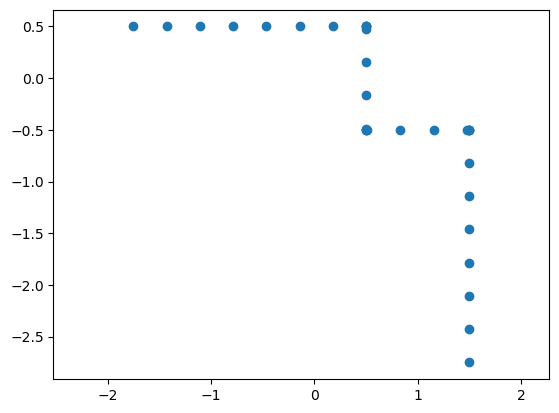

In [2]:
def init_trajectory(sofa_w, sofa_h, control_point_num, middle_rotation=-0.5 * np.pi, offset=1):  # 生成初始轨迹
    xs, ys, rotations = resample_polyline([
        [-sofa_w / 2, 0.5, 0],
        [0.5, 0.5, 0],
        [0.5, 0.5, middle_rotation],
        [0.5, 0.5 - offset, middle_rotation],
        [0.5, 0.5 - offset, 0],
        [0.5 + offset, 0.5 - offset, 0],
        [0.5 + offset, 0.5 - offset, middle_rotation],
        [0.5 + offset, -offset - sofa_w / 2, middle_rotation]
    ], control_point_num).T
    return xs, ys, rotations

offset = 1  # 前后走廊中线的距离，小于1时沙发无限大

sofa_w = 3.5   # 求解域的尺寸
sofa_h = 1.0   # 求解域的尺寸

xs, ys, rotations = init_trajectory(  # 初始轨迹
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    control_point_num=30,  # 轨迹的控制点数量
    middle_rotation=-0.3 * np.pi,
    offset=offset
)

plt.scatter(xs, ys)
plt.axis('equal')

In [ ]:
# xs, ys, rotations = np.load('../trajectory/双拐角_offset1/sofa_3394.npy')

In [ ]:
# from utils import monotonicly_interpolate

# keys = xs - ys  # 要求这个函数单调递增来重新采样
# xs, ys, rotations = monotonicly_interpolate(
#     keys,
#     np.array([xs, ys, rotations]).T,
#     len(xs) * 2 + 1,
#     key_min=keys[0],
#     key_max=keys[-1]
# ).T

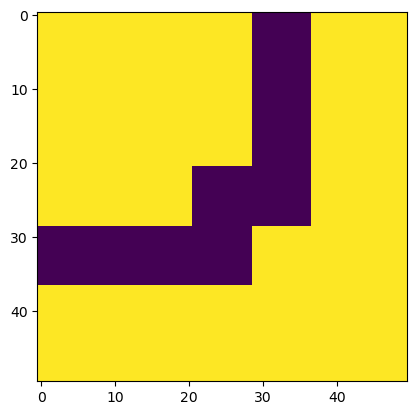

In [ ]:
# 确定布尔表达式

x, y = np.mgrid[0.5 - 3:0.5 + 3:50j, -0.5 - 3:-0.5 + 3:50j]

mask = np.logical_or(
    np.logical_or(
        x > 2,
        y > 1
    ),
    np.logical_or(
        np.logical_and(
            x > 1,
            y > 0
        ),
        np.logical_or(
            np.logical_and(
                x < 0,
                y < 0
            ),
            np.logical_and(
                x < 1,
                y < -1
            )
        )
    )
)

plt.imshow(mask.T)

Initial survivors: 0.8010103106498718
iter 500 / 200000, maximal_area=0.936078667640686
iter 1000 / 200000, maximal_area=1.1158262491226196
iter 1500 / 200000, maximal_area=1.1912089586257935
iter 2000 / 200000, maximal_area=1.2117869853973389
iter 2500 / 200000, maximal_area=1.2786363363265991
iter 3000 / 200000, maximal_area=1.309491753578186
iter 3500 / 200000, maximal_area=1.330432653427124
iter 4000 / 200000, maximal_area=1.3361331224441528
iter 4500 / 200000, maximal_area=1.3510926961898804
iter 5000 / 200000, maximal_area=1.3587596416473389
iter 5500 / 200000, maximal_area=1.3607261180877686
iter 6000 / 200000, maximal_area=1.3618731498718262
iter 6500 / 200000, maximal_area=1.3620136976242065
iter 7000 / 200000, maximal_area=1.3627276420593262
iter 7500 / 200000, maximal_area=1.3630789518356323
iter 8000 / 200000, maximal_area=1.3638280630111694
iter 8500 / 200000, maximal_area=1.3642377853393555
iter 9000 / 200000, maximal_area=1.3642611503601074
iter 9500 / 200000, maximal_ar

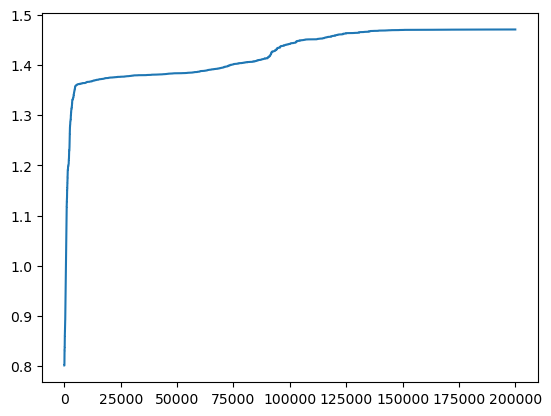

In [29]:
@ti.func
def is_forbidden(x, y):  # 指定哪里是墙
    return x > 2 or y > 1 or (x > 1 and y > 0) or (x < 0 and y < 0) or (x < 1 and y < -1)

best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
    is_forbidden,
    xs,
    ys,
    rotations,
    # initial_xs=zoom(xs, zoom=2, order=1),
    # initial_ys=zoom(ys, zoom=2, order=1),
    # initial_rotations=zoom(rotations, zoom=2, order=1),
    mutation_sigma_pos = 0.02,  # 变异率
    mutation_sigma_rotation = 0.004,  # 变异率
    iterations = 200000,  # 200000
    trajectory_upsampling=41,  # 41 101
    resolution=1024,  # 1024 2000
    print_every=500,  # 1000
    save_image_every=83,
    save_image_path='../images/连续拐角/sofa_',
    save_image_start_id=0,
    save_trajectory_path='../trajectory/连续拐角/sofa_'
)
print(f"Estimated maximal sofa area (by sampling): {best_score:.5f}")
# save mask image as PNG if pillow is available

img = (sofa * 255).astype(np.uint8)
im = Image.fromarray(img.T[::-1])
im.save('sofa_survivors.png')
print('Saved sofa_survivors.png')
plt.plot(maximal_area_record)